# Does Betelgeuse come from an assosication/Does it encounter an assosication in the last 20 Myr
 
This notebook contains code which aims to answer the question "Did the star Beteglues come from an association in the last 20 Myr"

## The steps:
- Lets grab all current info for Betelgeuse (ra, dec, pm, rv, etc.) that lets us compute its current position and velicity vectors. 
- After which lets orbit integrate to determine Betelgeuse's orbit over the last 20 Myr and see if it comes close to a known assosication?

## Some Deliverables : 
- Orbit for Betelgeuse
- Orbits for some number (500,000+) feild stars to see which ones come near Betelgeuse
- Animation (gif) that will follow Betelgeuse (in a small 100pc window) around its orbit to search for any high-density stellar assosiation that comes nearby


Lets load in some libraries first:

In [2]:
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import ICRS
import astropy.coordinates as apycord

from mpl_toolkits.mplot3d import Axes3D
from pyia import GaiaData

# Gala
import gala.dynamics as gd
import gala.potential as gp
%matplotlib widget
from startup import *
import gala.integrate as gi

ModuleNotFoundError: No module named 'pyia'

Lets define the Galactocentric frame and the sunes position and motion relative to it

In [53]:
with coord.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = coord.Galactocentric()

sun_xyz = u.Quantity(
    [-8.122*u.kpc, 0 * u.kpc, galcen_frame.z_sun]  # x,y,z
)
sun_vxyz = galcen_frame.galcen_v_sun
sun_vxyz

sun_w0 = gd.PhaseSpacePosition(pos=sun_xyz, vel=sun_vxyz)
print(sun_w0)

pos=(-8.122, 0., 0.0208) kpc
vel=(12.9, 245.6, 7.78) km / s


Lets define the Milky Way Potential using Gala and print its components 

In [23]:
mw_potential = gp.MilkyWayPotential()
mw_potential
for k, pot in mw_potential.items():
    print(f"{k}: {pot!r}")

disk: <MiyamotoNagaiPotential: m=6.80e+10, a=3.00, b=0.28 (kpc,Myr,solMass,rad)>
bulge: <HernquistPotential: m=5.00e+09, c=1.00 (kpc,Myr,solMass,rad)>
nucleus: <HernquistPotential: m=1.71e+09, c=0.07 (kpc,Myr,solMass,rad)>
halo: <NFWPotential: m=5.40e+11, r_s=15.62, a=1.00, b=1.00, c=1.00 (kpc,Myr,solMass,rad)>


Lets now compute the solar orbit to make sure everything is working (we will integrate a 4 Gyr orbit using steps of 0.5 Myr and plot it

[(-12.0, 12.0), (-12.0, 12.0), (-12.0, 12.0)]

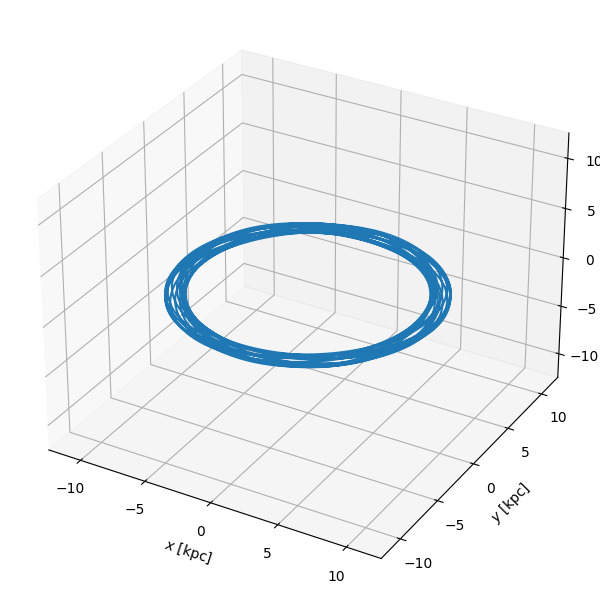

In [24]:
sun_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.5 * u.Myr, t1=0, t2=4 * u.Gyr,Integrator=gi.DOPRI853Integrator)
fig, ax = sun_orbit.plot_3d()

lim = (-12, 12)
ax.set(xlim=lim, ylim=lim, zlim=lim)

Lets now add the current information of Betelgeuse ! (current RA/DEC/PMRA/...)

In [43]:
#--put in the RA and DEC of BG


#BG_ra = 289.75228708; BG_dec =   41.63460623; BG_dist = 36.55263772
#pmra_BG = 94.63943807 ; pmdec_BG = -632.26859246
#rv_BG = -110.46822

#lBG = 266.4051 ; bBG = -28.936175
#XBG = BG_dist * np.cos(lBG*np.pi/180)*np.cos(bBG*np.pi/180) - 8.3 
#YBG = BG_dist * np.sin(lBG*np.pi/180)*np.cos(bBG*np.pi/180)
#ZBG = BG_dist * np.sin(bBG*np.pi/180)

Ok with the RA/DEC/PMRA/PMDEC/RV/Dist etc. now defined we need a way to convert this into the XYZ, UVW of Betelgeuse so that we have a starting point to integrate its orbit. 

Lets write a function that goes from the observables (RA/DEC/PMRA/PMDEC etc.) to the initial posititon and velocity of Betelgeuse.

In [34]:
# --- ok lets now compute some velocities with EDR3 data! We start by making a defintion to do this.
def compute_vels(ra, dec, pmra, pmdec, rv, dist, V0=[11.1, 12.24+235, 7.25], R0=8.122):
    # define an ICRS coord for each star
    icrs = ICRS(
        ra=ra * u.deg,
        dec=dec * u.deg,
        distance=dist * u.kpc,
        pm_ra_cosdec=pmra * u.mas / u.yr,
        pm_dec=pmdec * u.mas / u.yr,
        radial_velocity=rv * u.km / u.s,
    )
    print(icrs)
    # Define the Galactic non-rotating rest frame: (V0 = solar velocity in Galactic rest fram; R0 = solar radius)
    v_sun = apycord.CartesianDifferential(V0 * u.km / u.s)
    gc_frame = apycord.Galactocentric(galcen_distance=R0 * u.kpc, z_sun=25.0 * u.pc, galcen_v_sun=v_sun)
    # convert to GC frame
    cg = icrs.transform_to(gc_frame) 
    cg.representation= 'cartesian'
    VX = cg.v_x.value
    VY = cg.v_y.value
    VZ = cg.v_z.value
    

    return VX, VY, VZ,cg.x.value,cg.y.value,cg.z.value

Lets now define the initial starting posititon/velocity of Betelgeuse and itegrate its orbit to compare with the sun

In [51]:
cg = compute_vels(BG_ra, BG_dec, pmra_BG, pmdec_BG, rv_BG, BG_dist)

VXBG, VYBG, VZBG,XBG,YBG,ZBG = compute_vels(BG_ra, BG_dec, pmra_BG, pmdec_BG, rv_BG, BG_dist)
BG_xyz = (XBG,YBG,ZBG)*u.kpc ;  BG_vxvyvz = (VXBG, VYBG, VZBG)*u.km/u.s


<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (289.75228708, 41.63460623, 36.55263772)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (94.63943807, -632.26859246, -110.46822)>
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (289.75228708, 41.63460623, 36.55263772)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (94.63943807, -632.26859246, -110.46822)>


[(-12.0, 12.0), (-12.0, 12.0), (-12.0, 12.0)]

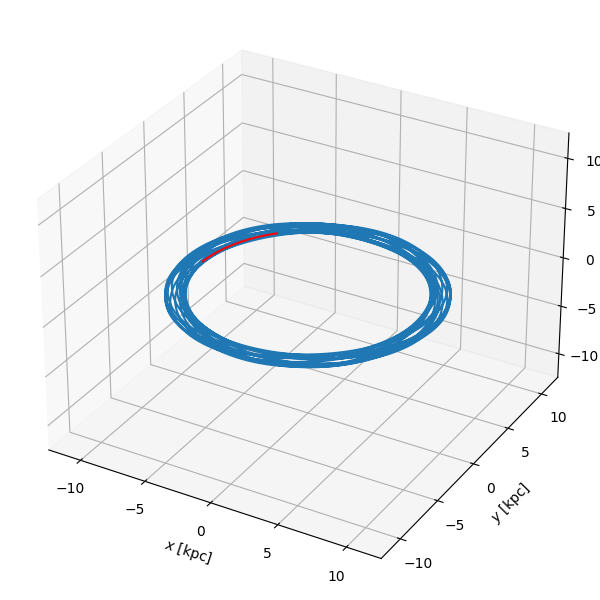

In [50]:
plt.close('all')
BG_w0 = gd.PhaseSpacePosition(star_galcen.data)
BG_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.05 * u.Myr, t1=0, t2=25 * u.Myr,Integrator=gi.DOPRI853Integrator)
fig, ax = sun_orbit.plot_3d()
fig1, ax1 = BG_orbit.plot_3d(ax=ax,color='r')

lim = (-12, 12)
ax.set(xlim=lim, ylim=lim, zlim=lim)


Ok so Betelgeuse appears to have gone around the MW about 1/10 of an orbit and in its time has an orbit that is probably very sightly interior to the sun.

Lets now load in all stars with RVs in Gaia from which we will compute their orbits to follow Betelgeuse around in its 20Myr orbit to see if it comes close to an assosiation of stars

In [9]:
D = Table.read('/Users/khawkins/Desktop/data/GaiaDR3/dr3-rv-good-plx-MilkyWayPotential2022-joined.fits')

In [10]:
print(D.colnames)
#p.figure()
#p.hexbin(D['xGC'], D['yGC'], bins='log',cmap='plasma')

['source_id', 'xyz', 'vxyz', 'actions', 'angles', 'freqs', 'E', 'L', 'ecc', 'r_apo', 'r_per', 'z_max', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ruwe', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error', 'non_single_star', 'has_xp_continuous', 'has_xp_sampled', 'has_rvs', 'astrophysical_parameters_teff_gspphot', 'astrophysical_parameters_logg_gspphot', 'astrophysical_parameters_mh_gspphot']


Lets plot up a CMD and select only Dwarf stars. Why remove the giants? Well because they probably are older the Betelgeuse(?) this is a simple hack to get rid of a ton of stars (because its easier to integrat 500,000 orbits than 7 million orbits).

In [11]:
D['absG'] = D['phot_g_mean_mag'] - 5*log10(1000./D['parallax']-1)
p.figure()
#p.hexbin(D['bp_rp'], D['absG'], bins='log',mincnt=1E-2)
Yi = 3.721*arange(0,4) -4.8
p.plot(arange(0,4),Yi)
p.gca().invert_yaxis()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
ok = where( (D['ruwe']<= 1.4) \
           & (D['absG']> 3.721*D['bp_rp'] -4.8))[0]
print(len(ok))
D = D[ok]
D['dist_BG'] = sqrt( (D['xyz'][:,0]-XBG)**2 +(D['xyz'][:,1]-YBG)**2 + (D['xyz'][:,2]-ZBG)**2 )
p.figure()
#p.hexbin(D['bp_rp'], D['absG'], bins='log',mincnt=1E-2)
p.gca().invert_yaxis()

10268877


ok now lets take only dwarfs and see how many stars we need to orbits for.

In [ ]:
okstars = where((D['dist_BG']<0.35))[0]
print('There are %i stars that we will track orbits for'%len(okstars))

Lets define the starting position and velocity vectors of the stars to integrate their orbits

In [ ]:
xyz = (D['xyz'][:,0][okstars], D['xyz'][:,1][okstars], D['xyz'][:,2][okstars])*u.kpc 
#the /1000. is converting from pc to kpc
vxvyvz =  ( D['vxyz'][:,0][okstars], D['vxyz'][:,1][okstars], D['vxyz'][:,2][okstars] )*u.km/u.s

In [ ]:
#vxo,vyo,vzo,xo,yo,zo= compute_vels(array(D['ra']), array(D['dec']), array(D['pmra']),array(D['pmdec']), array(D['vrad']), array(D['dist'])/1000.)
#xyz= (xo,yo,zo)*u.kpc ;  vxvyvz = (vxo,vyo,vzo)*u.km/u.s

Now lets run some orbits! This may take a while especially if there are 1E5 stars!! Hang tight.

In [ ]:
other_w0 = gd.PhaseSpacePosition(pos=xyz, vel=vxvyvz)
other_orbit = mw_potential.integrate_orbit(other_w0, dt=-0.1*u.Myr, n_steps=150,Integrator=gi.DOPRI853Integrator)


BG_w0 = gd.PhaseSpacePosition(pos=BG_xyz, vel=BG_vxvyvz)
BG_orbit = mw_potential.integrate_orbit(BG_w0,dt=-0.1*u.Myr, n_steps=150,Integrator=gi.DOPRI853Integrator)



In [ ]:
BG_w0 = gd.PhaseSpacePosition(pos=BG_xyz, vel=BG_vxvyvz)
BG_orbit = mw_potential.integrate_orbit(BG_w0,dt=-0.2*u.Myr, n_steps=100,Integrator=gi.DOPRI853Integrator)

Ok with the orbits of Betelgeuse and 500,000 stars or more lets create a simple statistic to ask whether Betelgeuse comes close to anything.

Heres the niieve statistic:
If Betelgeuse is suppose to enter an assosication/cluster at some point in its orbit, lets compute the median distance to the N (N=10?50?100??) nearest neighbors. This median distance should be small if Betelgeuse enters a cluster enviroment that is high density. 

Some drawbacks -- Rememeber that N is not known. If too small of an N is selected it wont 'see' cluster and it will be small sample statisics. If N is too large it will only track the field and not any cluster! So its key to visually inspect.

In [17]:
distBG_t = []
Nnearest = 10
med_nearestN_dist = []
std_nearestN_dist = []

for i in range(len(BG_orbit.x)):
    #---compute the distance to each star from Betelgeuse
    distBG_t.append(  sqrt( (other_orbit.x[i].value - BG_orbit.x[i].value)**2 + \
                           (other_orbit.y[i].value - BG_orbit.y[i].value)**2 +\
                           (other_orbit.z[i].value - BG_orbit.z[i].value)**2 )
                   )
    sorted_dists = argsort(array(distBG_t[i])) #sort the distances of each star to betelgeuse at each timestep
    med_nearestN_dist.append(nanmedian(distBG_t[i][sorted_dists[0:Nnearest]])) #take the nearest N neighbors and track the median dist
    #med_nearestN_dist.append( percentile(distBG_t[i],5) )
    std_nearestN_dist.append(nanstd(distBG_t[i][sorted_dists[0:Nnearest]]))
    
    


Lets plot the median distance that Betelgeuse is from N nearest neighbors as a function of the time in the orbit. 

In [18]:
#plot the 
p.close('all')
p.errorbar(BG_orbit.t.value,med_nearestN_dist,fmt='o',yerr=std_nearestN_dist )
p.xlabel('Time (Myr)'); p.ylabel('Median dist$_{%i}$ (kpc)'%Nnearest)
p.plot(BG_orbit.t.value,med_nearestN_dist,'-o',color='r',zorder=5,ms=3 )
iter = argmin(med_nearestN_dist)
p.axvline(x=BG_orbit.t.value[iter])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Well... crap... it doesnt come close to anything after 1-2 Myr ago.. Why.. maybe the Energy is not conserved and orbits cannot be trusted. 

Lets compute the level of Energy conservation

In [ ]:
#check the energy conservation
E = BG_orbit.energy()
print(np.mean((E[1:] - E[0]) / E[0]))
std(BG_orbit.energy())

O.. well looks like Energy is conserved to machine precision! Its not that

Lets now look at where Betelgeuse is at specific snapshots (iter = which iteration in the orbit to look at it and compare it to T= NOW)

In [ ]:
p.close('all')
p.figure()
iter = -1 #argmin(med_nearestN_dist)

ax1=p.subplot(1,3,1)
p.title('T = %.2f Myr'%other_orbit.t[iter].value)
#p.plot(other_orbit.x[iter],other_orbit.y[iter],'.',ms=3)
p.hexbin(other_orbit.x[iter],other_orbit.y[iter],cmap='Greys',bins='log',mincnt=1E-2,gridsize=500)
p.plot(BG_orbit.x[iter],BG_orbit.y[iter],'*',ms=10,color='orange',mec='k')
p.xlabel('X (kpc)'); p.ylabel('Y (kpc)')

ax2=p.subplot(1,3,2,sharex=ax1)
p.hexbin(other_orbit.x[iter],other_orbit.z[iter],cmap='Greys',bins='log',mincnt=1E-2,gridsize=500)
p.plot(BG_orbit.x[iter],BG_orbit.z[iter],'*',ms=10,color='orange',mec='k')
p.xlabel('X (kpc)'); p.ylabel('Z (kpc)')

ax2=p.subplot(1,3,3,sharey=ax2)
p.hexbin(other_orbit.y[iter],other_orbit.z[iter],cmap='Greys',bins='log',mincnt=1E-2,gridsize=500)
p.plot(BG_orbit.y[iter],BG_orbit.z[iter],'*',ms=10,color='orange',mec='k')
p.xlabel('Y (kpc)'); p.ylabel('Z (kpc)')


p.figure()
iter = 0
p.title('T = 0.00 Myr')
ax1=p.subplot(1,3,1)
p.hexbin(other_orbit.x[iter],other_orbit.y[iter],cmap='Greys',bins='log',mincnt=1E-2,gridsize=500)
p.plot(BG_orbit.x[iter],BG_orbit.y[iter],'*',ms=10,color='orange',mec='k')
p.xlabel('X (kpc)'); p.ylabel('Y (kpc)')

ax2=p.subplot(1,3,2,sharex=ax1)
p.hexbin(other_orbit.x[iter],other_orbit.z[iter],cmap='Greys',bins='log',mincnt=1E-2,gridsize=500)
p.plot(BG_orbit.x[iter],BG_orbit.z[iter],'*',ms=10,color='orange',mec='k')
p.xlabel('X (kpc)'); p.ylabel('Z (kpc)')

ax2=p.subplot(1,3,3,sharey=ax2)
p.hexbin(other_orbit.y[iter],other_orbit.z[iter],cmap='Greys',bins='log',mincnt=1E-2,gridsize=500)
p.plot(BG_orbit.y[iter],BG_orbit.z[iter],'*',ms=10,color='orange',mec='k')
p.xlabel('Y (kpc)'); p.ylabel('Z (kpc)')


Lets now plot the stellar density feild around a small window (+/- 100 pc) around Betelgeuse and we mark Betelgeuse by an orange star and an arrow for its current direction of motion.

In [ ]:
p.figure()
iteri =69

window=0.1
print(where(abs(BG_orbit.t.value+7) < 0.2 ))
inds = where((other_orbit.x[iteri].value > BG_orbit.x[iteri].value-window)&(other_orbit.x[iteri].value <  BG_orbit.x[iteri].value+window)\
             &(other_orbit.y[iteri].value >  BG_orbit.y[iteri].value-window)&(other_orbit.y[iteri].value <  BG_orbit.y[iteri].value+window)\
            &( abs(other_orbit.z[iteri].value-BG_orbit.z[iteri].value) < 0.05 ))[0]

s=p.hexbin(other_orbit.x[iteri][inds],other_orbit.y[iteri][inds],cmap='Greys',mincnt=1,gridsize=100,zorder=0,rasterized=True,\
           )
p.plot(BG_orbit.x[iteri],BG_orbit.y[iteri],'*',ms=19,color='orange',mec='k',zorder=4,rasterized=True)
p.quiver(BG_orbit.x[iteri].value,BG_orbit.y[iteri].value,BG_orbit.v_x[iteri].value,BG_orbit.v_y[iteri].value,\
         zorder=4,color='orange',scale=1,rasterized=True)
p.xlabel('X (kpc)'); p.ylabel('Y (kpc)')
p.title('%.2f Myr'%BG_orbit.t.value[iteri])
p.colorbar(s,label='N')
del iteri

In [5]:
p.close('all')

NameError: name 'p' is not defined

Lets now plot generalize the stellar density feild around a small window (+/- 100 pc) around Betelgeuse and we mark Betelgeuse by an orange star and an arrow for its current direction of motion! Lets make an animation which follows Betelgeuse around in its orbit to see if anything of high density comes nearby! 

In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(10,10))

def animate(iteri):
    ax.clear()
    window = 0.1
    inds = where((other_orbit.x[iteri].value > BG_orbit.x[iteri].value-window)&(other_orbit.x[iteri].value <  BG_orbit.x[iteri].value+window)\
                 &(other_orbit.y[iteri].value >  BG_orbit.y[iteri].value-window)&(other_orbit.y[iteri].value <  BG_orbit.y[iteri].value+window)&\
                ( abs(other_orbit.z[iteri].value-BG_orbit.z[iteri].value) < 0.1 ))[0]

    s=ax.hexbin(other_orbit.x[iteri][inds],other_orbit.y[iteri][inds],cmap='Greys',gridsize=50,mincnt=1,zorder=0,\
                rasterized=True)
    ax.plot(BG_orbit.x[iteri],BG_orbit.y[iteri],'*',ms=19,color='orange',mec='k',zorder=4,rasterized=True)
    ax.quiver(BG_orbit.x[iteri].value,BG_orbit.y[iteri].value,BG_orbit.v_x[iteri].value,BG_orbit.v_y[iteri].value,\
         zorder=4,color='orange',scale=1,rasterized=True)
    ax.set_xlabel('X (kpc)'); ax.set_ylabel('Y (kpc)')
    ax.set_title('%.2f Myr'%BG_orbit.t.value[iteri])
    #fig.colorbar(s,label='N')
    
F = arange(len(other_orbit.x)-1,0,-1)
ani = FuncAnimation(fig, animate, frames=F, interval=200, repeat=True)
filename = r"/Users/khawkins/Desktop/BG_orbit_DR3.gif" 
writergif = animation.PillowWriter(fps=2.5) 
ani.save(filename, writer=writergif)
#from IPython.display import HTML
#HTML(ani.to_jshtml())
p.close('all')
 


In [ ]:
p.close('all')

In [ ]:
other_orbit.energy()[-1].value

Finally, to check something that Kathryn mentioned, lets plot the location of Betelgeuse (orange star) and a background feild in the integrals of motion (E-Lz) 

In [ ]:
p.close('all')
p.figure()
iter = -1
indi = where((other_orbit.energy()[iter].value > -0.15)&(other_orbit.energy()[iter].value < -0.1)&\
             (other_orbit.angular_momentum()[2][iter].value>-2.05)& (other_orbit.angular_momentum()[2][iter].value<-1.9))[0]
#p.plot(other_orbit.x[iter],other_orbit.y[iter],'.',ms=3)
p.hexbin(other_orbit.energy()[iter][indi],other_orbit.angular_momentum()[2][iter][indi],cmap='Greys',bins='log',mincnt=1E-2,gridsize=300)
p.plot(BG_orbit.energy()[iter],BG_orbit.angular_momentum()[2][iter],'*',ms=10,color='orange',alpha=0.3)
p.xlabel('E (kpc$^2$/Myr$^2$)'); p.ylabel('L$_z$ (kpc$^2$/Myr)')

Now lets plot the encounter distance and relative velocity to all stars within some box (window) of BG. What we are looking for here are stars that have both low (near 0) enounter distances and velocities. 

In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(10,10))
    
    
def animate_2(iteri):
    ax.clear()
    window = 0.4
    inds = where((other_orbit.x[iteri].value > BG_orbit.x[iteri].value-window)&(other_orbit.x[iteri].value <  BG_orbit.x[iteri].value+window)\
                 &(other_orbit.y[iteri].value >  BG_orbit.y[iteri].value-window)&(other_orbit.y[iteri].value <  BG_orbit.y[iteri].value+window)&\
                ( abs(other_orbit.z[iteri].value-BG_orbit.z[iteri].value) < BG_orbit.z[iteri].value+window ))[0]
    
    encounter_dist = sqrt( (other_orbit.x[iteri][inds].value-BG_orbit.x[iteri].value)**2 + \
                          (other_orbit.y[iteri][inds].value-BG_orbit.y[iteri].value)**2 +(other_orbit.z[iteri][inds].value-BG_orbit.z[iteri].value)**2)

    
    encounter_V = sqrt( (other_orbit.v_x[iteri][inds].value-BG_orbit.v_x[iteri].value)**2 + \
                          (other_orbit.v_y[iteri][inds].value-BG_orbit.v_y[iteri].value)**2 +(other_orbit.v_z[iteri][inds].value-BG_orbit.v_z[iteri].value)**2)
    
    s=ax.hexbin(encounter_V,encounter_dist*1000.,cmap='Greys',gridsize=150,mincnt=1,zorder=0,\
                rasterized=True,marginals=True)
    outside_3sig = where((encounter_dist < nanmedian(encounter_dist)-3*nanstd(encounter_dist)) |\
                         (encounter_V < nanmedian(encounter_V)-3*nanstd(encounter_V))  )
    p.plot(encounter_V[outside_3sig],encounter_dist[outside_3sig]*1000.,'.',ms=3,zorder=2)
    ax.set_xlabel('Encounter Velocity (km/s)'); ax.set_ylabel('Encounter Dist (pc)')
    ax.set_title('%.2f Myr'%BG_orbit.t.value[iteri])
    #fig.colorbar(s,label='N')
    
F = arange(len(other_orbit.x)-1,0,-1)
ani2 = FuncAnimation(fig, animate_2, frames=F, interval=100, repeat=True)
filename = r"/Users/khawkins/Desktop/BG_encounterdist.gif" 
writergif = animation.PillowWriter(fps=3) 
ani2.save(filename, writer=writergif)
#from IPython.display import HTML
#HTML(ani.to_jshtml())
p.close('all')
 
